# 1. Setup

In [1]:
#!pip install gym-super-mario-bros
#!pip install nes-py

In [2]:
#Imports
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT



Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [3]:
env = gym_super_mario_bros.make('SuperMarioBros-v0',apply_api_compatibility=True,render_mode="human" )
env = JoypadSpace(env, SIMPLE_MOVEMENT)

/Users/mateusluz/anaconda3/lib/python3.11/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/Users/mateusluz/anaconda3/lib/python3.11/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


In [4]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [5]:
done = True
for step in range(10000):
    if done:
        env.reset()
    state, reward, done, info, _ = env.step(env.action_space.sample())
    env.render()
env.close()

2025-08-30 15:14:12.833 python[1961:8664253] +[IMKClient subclass]: chose IMKClient_Modern
2025-08-30 15:14:12.932 python[1961:8664253] +[IMKInputSession subclass]: chose IMKInputSession_Modern
/Users/mateusluz/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/Users/mateusluz/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(
/Users/mateusluz/anaconda3/lib/python3.11/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


# Preprocessing
The quality of the AI will depend on the quality of data
That is why preprocessing the data is important. The techniques used are Greyscaling and Framestacking

  • Greyscaling: converting images from color to shades of gray to reduce complexity and focus on key features.  
  • Framestacking: combining several consecutive frames into one input so the model can capture motion and temporal context.  


In [ ]:
#!pip3 install torch torchvision
#!pip install 'stable-baselines3[extra]'

In [6]:
from gym.wrappers import FrameStack, GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt

In [7]:
class JoypadSpaceCompat(JoypadSpace):
    def reset(self, **kwargs):
        obs = super().reset()
        return obs, {}



In [8]:
# Create Base Env
env = gym_super_mario_bros.make('SuperMarioBros-v0',apply_api_compatibility=True,render_mode="human" )
# Define Controls
env = JoypadSpaceCompat(env, SIMPLE_MOVEMENT)
# Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# Wrap in Dummy Env

env = DummyVecEnv([lambda: env])
# Framestacking
env = VecFrameStack(env, 4, channels_order='last')

/Users/mateusluz/anaconda3/lib/python3.11/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/Users/mateusluz/anaconda3/lib/python3.11/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
/Users/mateusluz/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
state = env.reset() 

In [10]:
state[0].shape


(256, 3)

## GrayScalled Mario Screen

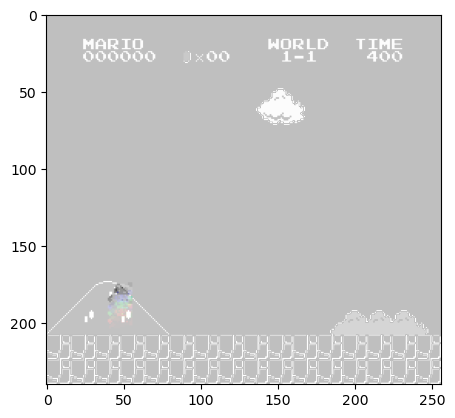

In [26]:
plt.imshow(state[0])

In [18]:
state, reward, done, info = env.step([5])

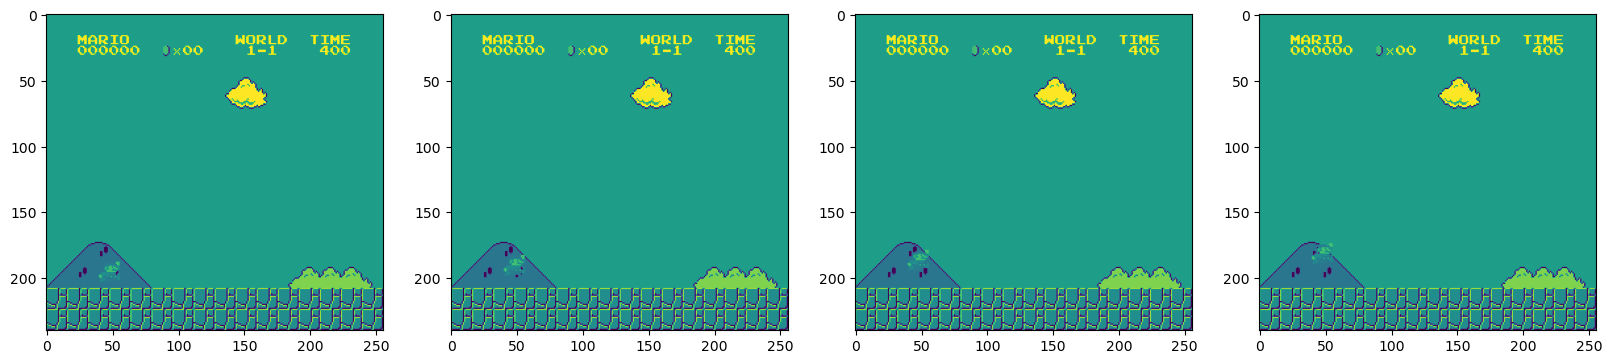

In [19]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()


## Training RL Model


In [20]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [21]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True


In [22]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'


In [23]:
callback = TrainAndLoggingCallback(check_freq=200000, save_path=CHECKPOINT_DIR)


In [24]:
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 


Using cpu device
Wrapping the env in a VecTransposeImage.


In [ ]:
model.learn(total_timesteps=1000000, callback=callback)


## Testing Model Performance


In [ ]:
model = PPO.load('./train/best_model_1000000')


In [ ]:
state = env.reset()


In [ ]:
# Start the game 
state = env.reset()
# Loop through the game
while True: 
    
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()
